<a href="https://colab.research.google.com/github/BuxinSu/Census_2020_Privacy/blob/main/Figures/Downstream_Tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DGM

This is the discrete Gaussian sampler
See the paper https://arxiv.org/abs/2004.00010
Now running some basic testing code
Start by calculating normalizing constant and variance for different values
sigma^2=1.0000000000000056e-100:	norm_const=1.0=sqrt{2*pi}*sigma*3.9894228040143154e+49	var=0.0
sigma^2=1.0000000000000004e-06:	norm_const=1.0=sqrt{2*pi}*sigma*398.9422804014326	var=0.0
sigma^2=0.001:	norm_const=1.0=sqrt{2*pi}*sigma*12.6156626101008	var=1.4249152813482571e-217
sigma^2=0.01:	norm_const=1.0=sqrt{2*pi}*sigma*3.989422804014327	var=1.9287498479639178e-22
sigma^2=0.03:	norm_const=1.0000001155549705=sqrt{2*pi}*sigma*2.3032945959660114	var=1.1555495703925331e-07
sigma^2=0.05:	norm_const=1.000090799859525=sqrt{2*pi}*sigma*1.7842861143718929	var=9.07916156590598e-05
sigma^2=0.08:	norm_const=1.0038609083002312=sqrt{2*pi}*sigma*1.4159196694844496	var=0.0038460591020486826
sigma^2=0.1:	norm_const=1.0134758981204781=sqrt{2*pi}*sigma*1.2785669994156845	var=0.013296725173624149
sigma^2=0.15:

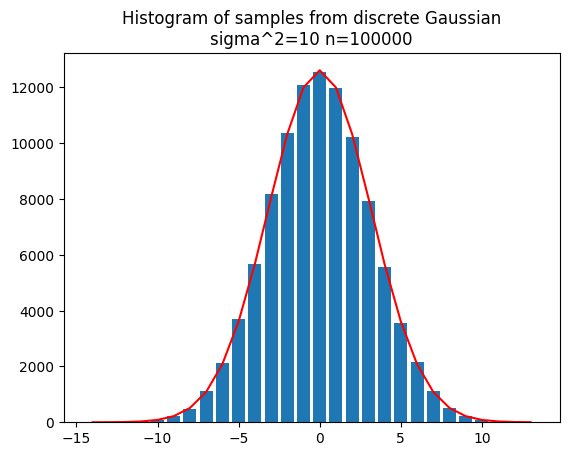

<Figure size 640x480 with 0 Axes>

In [ ]:
# Implementation of exact discrete gaussian distribution sampler
# See https://arxiv.org/abs/2004.00010
# - Thomas Steinke dgauss@thomas-steinke.net 2020

import random #Default random number generator,
#random.SecureRandom() provides high-quality randomness from /dev/urandom or similar
from fractions import Fraction #we will work with rational numbers

#sample uniformly from range(m)
#all randomness comes from calling this
def sample_uniform(m,rng):
    assert isinstance(m,int) #python 3
    #assert isinstance(m,(int,long)) #python 2
    assert m>0
    return rng.randrange(m)

#sample from a Bernoulli(p) distribution
#assumes p is a rational number in [0,1]
def sample_bernoulli(p,rng):
    assert isinstance(p,Fraction)
    assert 0 <= p <= 1
    m=sample_uniform(p.denominator,rng)
    if m < p.numerator:
        return 1
    else:
        return 0

#sample from a Bernoulli(exp(-x)) distribution
#assumes x is a rational number in [0,1]
def sample_bernoulli_exp1(x,rng):
    assert isinstance(x,Fraction)
    assert 0 <= x <= 1
    k=1
    while True:
        if sample_bernoulli(x/k,rng)==1:
            k=k+1
        else:
            break
    return k%2

#sample from a Bernoulli(exp(-x)) distribution
#assumes x is a rational number >=0
def sample_bernoulli_exp(x,rng):
    assert isinstance(x,Fraction)
    assert x >= 0
    #Sample floor(x) independent Bernoulli(exp(-1))
    #If all are 1, return Bernoulli(exp(-(x-floor(x))))
    while x>1:
        if sample_bernoulli_exp1(Fraction(1,1),rng)==1:
            x=x-1
        else:
            return 0
    return sample_bernoulli_exp1(x,rng)

#sample from a geometric(1-exp(-x)) distribution
#assumes x is a rational number >= 0
def sample_geometric_exp_slow(x,rng):
    assert isinstance(x,Fraction)
    assert x >= 0
    k=0
    while True:
        if sample_bernoulli_exp(x,rng)==1:
            k=k+1
        else:
            return k

#sample from a geometric(1-exp(-x)) distribution
#assumes x >= 0 rational
def sample_geometric_exp_fast(x,rng):
    assert isinstance(x,Fraction)
    if x==0: return 0 #degenerate case
    assert x>0

    t=x.denominator
    while True:
        u=sample_uniform(t,rng)
        b=sample_bernoulli_exp(Fraction(u,t),rng)
        if b==1:
            break
    v=sample_geometric_exp_slow(Fraction(1,1),rng)
    value = v*t+u
    return value//x.numerator

#sample from a discrete Laplace(scale) distribution
#Returns integer x with Pr[x] = exp(-abs(x)/scale)*(exp(1/scale)-1)/(exp(1/scale)+1)
#casts scale to Fraction
#assumes scale>=0
def sample_dlaplace(scale,rng=None):
    if rng is None:
        rng = random.SystemRandom()
    scale = Fraction(scale)
    assert scale >= 0
    while True:
        sign=sample_bernoulli(Fraction(1,2),rng)
        magnitude=sample_geometric_exp_fast(1/scale,rng)
        if sign==1 and magnitude==0: continue
        return magnitude*(1-2*sign)

#compute floor(sqrt(x)) exactly
#only requires comparisons between x and integer
def floorsqrt(x):
    assert x >= 0
    #a,b integers
    a=0 #maintain a^2<=x
    b=1 #maintain b^2>x
    while b*b <= x:
        b=2*b #double to get upper bound
    #now do binary search
    while a+1<b:
        c=(a+b)//2 #c=floor((a+b)/2)
        if c*c <= x:
            a=c
        else:
            b=c
    #check nothing funky happened
    #assert isinstance(a,int) #python 3
    #assert isinstance(a,(int,long)) #python 2
    return a

#sample from a discrete Gaussian distribution N_Z(0,sigma2)
#Returns integer x with Pr[x] = exp(-x^2/(2*sigma2))/normalizing_constant(sigma2)
#mean 0 variance ~= sigma2 for large sigma2
#casts sigma2 to Fraction
#assumes sigma2>=0
def sample_dgauss(sigma2,rng=None):
    if rng is None:
        rng = random.SystemRandom()
    sigma2=Fraction(sigma2)
    if sigma2==0: return 0 #degenerate case
    assert sigma2 > 0
    t = floorsqrt(sigma2)+1
    while True:
        candidate = sample_dlaplace(t,rng=rng)
        bias=((abs(candidate)-sigma2/t)**2)/(2*sigma2)
        if sample_bernoulli_exp(bias,rng)==1:
            return candidate

#########################################################################
#DONE That's it! Now some utilities

import math #need this, code below is no longer exact

#Compute the normalizing constant of the discrete gaussian
#i.e. sum_{x in Z} exp(-x^2/2sigma2)
#By Poisson summation formula, this is equivalent to
# sqrt{2*pi*sigma2}*sum_{y in Z} exp(-2*pi^2*sigma2*y^2)
#For small sigma2 the former converges faster
#For large sigma2, the latter converges faster
#crossover at sigma2=1/2*pi
#For intermediate sigma2, this code will compute both and check
def normalizing_constant(sigma2):
    original=None
    poisson=None
    if sigma2<=1:
        original = 0
        x=1000 #summation stops at exp(-x^2/2sigma2)<=exp(-500,000)
        while x>0:
            original = original + math.exp(-x*x/(2.0*sigma2))
            x = x - 1 #sum from small to large for improved accuracy
        original = 2*original + 1 #symmetrize and add x=0
    if sigma2*100 >= 1:
        poisson = 0
        y = 1000 #summation stops at exp(-y^2*2*pi^2*sigma2)<=exp(-190,000)
        while y>0:
            poisson = poisson + math.exp(-math.pi*math.pi*sigma2*2*y*y)
            y = y - 1 #sum from small to large
        poisson = math.sqrt(2*math.pi*sigma2)*(1+2*poisson)
    if poisson is None: return original
    if original is None: return poisson
    #if we have computed both, check equality
    scale = max(1,math.sqrt(2*math.pi*sigma2)) #tight-ish lower bound on constant
    assert -1e-15*scale <= original-poisson <= 1e-15*scale
    #10^-15 is about as much precision as we can expect from double precision floating point numbers
    #64-bit float has 56-bit mantissa 10^-15 ~= 2^-50
    return (original+poisson)/2

#compute the variance of discrete gaussian
#mean is zero, thus:
#var = sum_{x in Z} x^2*exp(-x^2/(2*sigma2)) / normalizing_constant(sigma2)
#By Poisson summation formula, we have equivalent expression:
# variance(sigma2) = sigma2 * (1 - 4*pi^2*sigma2*variance(1/(4*pi^2*sigma2)) )
#See lemma 20 https://arxiv.org/pdf/2004.00010v3.pdf#page=17
#alternative expression converges faster when sigma2 is large
#crossover point (in terms of convergence) is sigma2=1/(2*pi)
#for intermediate values of sigma2, we compute both expressions and check
def variance(sigma2):
    original=None
    poisson=None
    if sigma2<=1: #compute primary expression
        original=0
        x = 1000 #summation stops at exp(-x^2/2sigma2)<=exp(-500,000)
        while x>0: #sum from small to large for improved accuracy
            original = original + x*x*math.exp(-x*x/(2.0*sigma2))
            x=x-1
        original = 2*original/normalizing_constant(sigma2)
    if sigma2*100>=1:
        poisson=0 #we will compute sum_{y in Z} y^2 * exp(-2*pi^2*sigma2*y^2)
        y=1000 #summation stops at exp(-y^2*2*pi^2*sigma2)<=exp(-190,000)
        while y>0: #sum from small to large
            poisson = poisson + y*y*math.exp(-y*y*2*sigma2*math.pi*math.pi)
            y=y-1
        poisson = 2*poisson/normalizing_constant(1/(4*sigma2*math.pi*math.pi))
        #next convert from variance(1/(4*pi^2*sigma2)) to variance(sigma2)
        poisson = sigma2*(1-4*sigma2*poisson*math.pi*math.pi)
    if original is None: return poisson
    if poisson is None: return original
    #if we have computed both check equality
    assert -1e-15*sigma2 <= original-poisson <= 1e-15*sigma2
    return (original+poisson)/2

#########################################################################
#DONE Now some basic testing code

import matplotlib.pyplot as plt #only needed for testing
import time #only needed for testing

#This generates n samples from sample_dgauss(sigma2)
#It times this and releases statistics
#produces a histogram plot if plot==True
#if plot==None it will only produce a histogram if it's not too large
#can save image instead of displaying by specifying a path  e.g., save="plot.png"
def plot_histogram(sigma2,n,save=None,plot=None):
    #generate samples
    before=time.time()
    samples = [sample_dgauss(sigma2) for i in range(n)]
    after=time.time()
    print("generated "+str(n)+" samples in "+str(after-before)+" seconds ("+str(n/(after-before))+" samples per second) for sigma^2="+str(sigma2))
    #now process
    samples.sort()
    values=[]
    counts=[]
    counter=None
    prev=None
    for sample in samples:
        if prev is None: #initializing
            prev=sample
            counter=1
        elif sample==prev: #still same element
            counter=counter+1
        else:
            #add prev to histogram
            values.append(prev)
            counts.append(counter)
            #start counting
            prev=sample
            counter=1
    #add final value
    values.append(prev)
    counts.append(counter)

    #print & sum
    sum=0
    sumsquared=0
    kl=0 #compute KL divergence betwen empirical distribution and true distribution
    norm_const=normalizing_constant(sigma2)
    true_var=variance(sigma2)
    for i in range(len(values)):
        if len(values)<=100: #don't print too much
            print(str(values[i])+":\t"+str(counts[i]))
        sum = sum + values[i]*counts[i]
        sumsquared = sumsquared + values[i]*values[i]*counts[i]
        kl = kl + counts[i]*(math.log(counts[i]*norm_const/n)+values[i]*values[i]/(2.0*sigma2))
    mean = Fraction(sum,n)
    var=Fraction(sumsquared,n)
    kl=kl/n
    print("mean="+str(float(mean))+" (true=0)")
    print("variance="+str(float(var))+" (true="+str(true_var)+")")
    print("KL(empirical||true)="+str(kl)) # https://en.wikipedia.org/wiki/G-test
    assert kl>0 #kl divergence always >=0 and ==0 iff empirical==true, which is impossible
    #now plot
    if plot is None:
        plot = (len(values)<=1000) #don't plot if huge
    if not plot: return
    ideal_counts = [n*math.exp(-x*x/(2.0*sigma2))/norm_const for x in values]
    plt.bar(values, counts)
    plt.plot(values, ideal_counts,'r')
    plt.title("Histogram of samples from discrete Gaussian\nsigma^2="+str(sigma2)+" n="+str(n))
    if save is None:
        plt.show()
    else:
        plt.savefig(save)
    plt.clf()

if __name__ == '__main__':
    print("This is the discrete Gaussian sampler")
    print("See the paper https://arxiv.org/abs/2004.00010")
    print("Now running some basic testing code")
    print("Start by calculating normalizing constant and variance for different values")
    #some test code for normalizing_constant and variance functions
    for sigma2 in [0.1**100,0.1**6,0.001,0.01,0.03,0.05,0.08,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,10,100,10**6,10**20,10**100]:
        #internal asserts do some testing when 0.01<=sigma2<=1
        c=normalizing_constant(sigma2)
        v=variance(sigma2)
        #print
        print("sigma^2="+str(sigma2) + ":\tnorm_const=" + str(c) + "=sqrt{2*pi}*sigma*" + str(c/math.sqrt(2*math.pi*sigma2)) + "\tvar=" + str(v))
    #print a few samples
    #for i in range(20): print sample_dgauss(1)
    #plot histogram and statistics
    #includes timing
    print("Now run the sampler")
    print("Start with very large sigma^2=10^100 -- for timing purposes only")
    plot_histogram(10**100,100000,plot=False) #large var, this will just be for timing
    print("Now sigma^2=10 -- will display a histogram")
    plot_histogram(10,100000) #small var, this will produce plot



# **Clean Data**

In [ ]:
from sklearn.isotonic import isotonic_regression
from sklearn.linear_model import LinearRegression
import cvxpy as cp
import numpy as np
import csv, os
from scipy import stats
from sklearn import metrics
import itertools
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statistics
from scipy.stats import levene
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

!apt-get install -y texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super

# Set the text properties to use LaTeX fonts with Computer Modern
plt.rcParams.update({
    'text.usetex': True,  # Use LaTeX for rendering text
    'font.family': 'serif',  # Use a serif font family (which will be Computer Modern)
    'font.serif': ['Computer Modern Roman'],  # Explicitly use the Computer Modern font
    'axes.unicode_minus': False,  # Ensure minus signs are displayed correctly
    'font.size': 20,  #In a row, use 20 for single picture, # 30 for double figures, # 55 for four figures
    'figure.figsize': (13, 8),  # Figure size in inches
    'figure.dpi': 300,  # Dots per inch (high resolution)
})

def format_func(value, tick_number):
    if value < 10:
        return f"{value:.2f}"
    elif value < 100:
        return f"{value:.1f}"
    else:
        return f"{int(value)}"




# Replace this with the path to your CSV file in Google Drive
file_path = '/content/drive/MyDrive/Research/Discrete Gaussian Mechanism/Results_2024_09_10/Downstream_tasks/subcounty_down.csv'

data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
# data


data = data[['S1501_C01_006E', 'S1501_C01_007E', 'S1501_C01_008E', 'S1501_C01_009E', 'S1501_C01_010E', 'S1501_C01_011E', 'S1501_C01_015E','S1501_C01_059E']]

data = data[~data.applymap(lambda x: x == '-').any(axis=1)]

data.reset_index(drop=True, inplace=True)

data = data.astype(str).replace('2,500', '2500', regex=True)

data



<ipython-input-3-24f2104b1c47>:19: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,174,175,176,177,180,181,182,183,186,187,188,189,192,193,194,195,240,241,242,243,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,398,399,400,401,402,403,404,405,

,S1501_C01_006E,S1501_C01_007E,S1501_C01_008E,S1501_C01_009E,S1501_C01_010E,S1501_C01_011E,S1501_C01_015E,S1501_C01_059E
0,Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT...,Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT...,Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT...,Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT...,Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT...,Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT...,Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT...,Estimate!!Total!!MEDIAN EARNINGS IN THE PAST 1...
1,555,15,58,265,87,84,46,34375
2,539,24,28,209,78,47,153,36786
3,465,65,18,239,47,20,76,35324
4,1649,58,97,762,292,172,268,38149
...,...,...,...,...,...,...,...,...
2549,595,8,40,245,158,25,119,30938
2550,27138,2037,3588,11235,3952,2317,4009,30952
2551,19611,479,778,6638,3354,1903,6459,47997
2552,148,6,12,77,29,11,13,37344


In [ ]:
new_header = data.iloc[0] # Take the second row for the header

# Delete the first row
data_cleaned = data.drop(index=0)


data_cleaned = data_cleaned[1:] # Take the data less the second row
data_cleaned.columns = new_header # Set the header row as the dataframe header

# Now that we have renamed the columns, we need to reset the index
data_cleaned.reset_index(drop=True, inplace=True)

data_cleaned

,Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over,Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Less than 9th grade,"Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!9th to 12th grade, no diploma",Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school graduate (includes equivalency),"Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Some college, no degree",Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Associate's degree,Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree or higher,Estimate!!Total!!MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2020 INFLATION-ADJUSTED DOLLARS)!!Population 25 years and over with earnings
0,539,24,28,209,78,47,153,36786
1,465,65,18,239,47,20,76,35324
2,1649,58,97,762,292,172,268,38149
3,792,24,81,367,129,57,134,36750
4,1264,25,59,472,323,155,230,40752
...,...,...,...,...,...,...,...,...
2547,595,8,40,245,158,25,119,30938
2548,27138,2037,3588,11235,3952,2317,4009,30952
2549,19611,479,778,6638,3354,1903,6459,47997
2550,148,6,12,77,29,11,13,37344


In [ ]:
# Rename the columns as specified: 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'
new_column_names = ['Population 25 years and over', 'Less than 9th grade', '9th to 12th grade', 'High school graduate', 'Some college', 'Associate degree', 'Bachelor degree or higher', 'Earnings']
data_cleaned.columns = new_column_names[:len(data_cleaned.columns)]

data = data_cleaned

data

,Population 25 years and over,Less than 9th grade,9th to 12th grade,High school graduate,Some college,Associate degree,Bachelor degree or higher,Earnings
0,539,24,28,209,78,47,153,36786
1,465,65,18,239,47,20,76,35324
2,1649,58,97,762,292,172,268,38149
3,792,24,81,367,129,57,134,36750
4,1264,25,59,472,323,155,230,40752
...,...,...,...,...,...,...,...,...
2547,595,8,40,245,158,25,119,30938
2548,27138,2037,3588,11235,3952,2317,4009,30952
2549,19611,479,778,6638,3354,1903,6459,47997
2550,148,6,12,77,29,11,13,37344


# No DP

In [ ]:
# Transpose the dataset for easier manipulation
data_transposed = data.T

# Display the transposed dataframe
data_transposed = data_transposed.astype(float)

data_transposed

,0,1,2,3,4,5,6,7,8,9,...,2542,2543,2544,2545,2546,2547,2548,2549,2550,2551
Population 25 years and over,539.0,465.0,1649.0,792.0,1264.0,1951.0,3015.0,5253.0,4957.0,1101.0,...,2854.0,777.0,12772.0,441.0,1460.0,595.0,27138.0,19611.0,148.0,581.0
Less than 9th grade,24.0,65.0,58.0,24.0,25.0,96.0,38.0,248.0,151.0,51.0,...,76.0,81.0,223.0,13.0,58.0,8.0,2037.0,479.0,6.0,6.0
9th to 12th grade,28.0,18.0,97.0,81.0,59.0,217.0,111.0,219.0,191.0,79.0,...,411.0,88.0,527.0,51.0,155.0,40.0,3588.0,778.0,12.0,63.0
High school graduate,209.0,239.0,762.0,367.0,472.0,796.0,948.0,2219.0,1299.0,429.0,...,1299.0,231.0,5075.0,216.0,720.0,245.0,11235.0,6638.0,77.0,277.0
Some college,78.0,47.0,292.0,129.0,323.0,321.0,795.0,835.0,915.0,169.0,...,452.0,182.0,2429.0,68.0,192.0,158.0,3952.0,3354.0,29.0,147.0
Associate degree,47.0,20.0,172.0,57.0,155.0,111.0,399.0,599.0,372.0,122.0,...,385.0,85.0,1243.0,23.0,178.0,25.0,2317.0,1903.0,11.0,51.0
Bachelor degree or higher,153.0,76.0,268.0,134.0,230.0,410.0,724.0,1133.0,2029.0,251.0,...,231.0,110.0,3275.0,70.0,157.0,119.0,4009.0,6459.0,13.0,37.0
Earnings,36786.0,35324.0,38149.0,36750.0,40752.0,32147.0,47583.0,42248.0,44172.0,36779.0,...,29160.0,36250.0,49064.0,36458.0,33484.0,30938.0,30952.0,47997.0,37344.0,32464.0


In [ ]:
# Calculate the sum of the rows 1 to 4 (which are 2nd to 5th rows in 0-indexed dataframe)
sum_of_rows = data_transposed.iloc[1:7].sum(axis=0)

# Replace the 'Population 25 years and over' row with this sum
data_transposed.loc['Population 25 years and over'] = sum_of_rows

# Reset the index to make sure the changes persist
# data_transposed.reset_index(drop=True, inplace=True)

# Now let's see if the first row has been correctly updated to the sum of the specified rows
data_transposed


,0,1,2,3,4,5,6,7,8,9,...,2542,2543,2544,2545,2546,2547,2548,2549,2550,2551
Population 25 years and over,539.0,465.0,1649.0,792.0,1264.0,1951.0,3015.0,5253.0,4957.0,1101.0,...,2854.0,777.0,12772.0,441.0,1460.0,595.0,27138.0,19611.0,148.0,581.0
Less than 9th grade,24.0,65.0,58.0,24.0,25.0,96.0,38.0,248.0,151.0,51.0,...,76.0,81.0,223.0,13.0,58.0,8.0,2037.0,479.0,6.0,6.0
9th to 12th grade,28.0,18.0,97.0,81.0,59.0,217.0,111.0,219.0,191.0,79.0,...,411.0,88.0,527.0,51.0,155.0,40.0,3588.0,778.0,12.0,63.0
High school graduate,209.0,239.0,762.0,367.0,472.0,796.0,948.0,2219.0,1299.0,429.0,...,1299.0,231.0,5075.0,216.0,720.0,245.0,11235.0,6638.0,77.0,277.0
Some college,78.0,47.0,292.0,129.0,323.0,321.0,795.0,835.0,915.0,169.0,...,452.0,182.0,2429.0,68.0,192.0,158.0,3952.0,3354.0,29.0,147.0
Associate degree,47.0,20.0,172.0,57.0,155.0,111.0,399.0,599.0,372.0,122.0,...,385.0,85.0,1243.0,23.0,178.0,25.0,2317.0,1903.0,11.0,51.0
Bachelor degree or higher,153.0,76.0,268.0,134.0,230.0,410.0,724.0,1133.0,2029.0,251.0,...,231.0,110.0,3275.0,70.0,157.0,119.0,4009.0,6459.0,13.0,37.0
Earnings,36786.0,35324.0,38149.0,36750.0,40752.0,32147.0,47583.0,42248.0,44172.0,36779.0,...,29160.0,36250.0,49064.0,36458.0,33484.0,30938.0,30952.0,47997.0,37344.0,32464.0


In [ ]:
# Isolating the rows for "Bachelor's degree or higher" and "Population 25 to 64 years"
bachelors_or_higher = data_transposed.iloc[-2]

population_25_to_64 = data_transposed.iloc[0]

print(bachelors_or_higher)
print(population_25_to_64)

0        153.0
1         76.0
2        268.0
3        134.0
4        230.0
         ...  
2547     119.0
2548    4009.0
2549    6459.0
2550      13.0
2551      37.0
Name: Bachelor degree or higher, Length: 2552, dtype: float64
0         539.0
1         465.0
2        1649.0
3         792.0
4        1264.0
         ...   
2547      595.0
2548    27138.0
2549    19611.0
2550      148.0
2551      581.0
Name: Population 25 years and over, Length: 2552, dtype: float64


In [ ]:
# Calculating the percentage
percentage_bachelors_or_higher = (bachelors_or_higher / population_25_to_64) * 10000
# print(percentage_bachelors_or_higher)

# # Adding this as a new row
# data['Percentage of Bachelors or Higher'] = percentage_bachelors_or_higher

# # Transpose the dataset for easier manipulation
# data_transposed = pd.DataFrame(data.T)

# data_transposed = data_transposed.append(pd.DataFrame([percentage_bachelors_or_higher], index=['Percentage Bachelors or Higher']))

# Display the updated dataframe
data_transposed


,0,1,2,3,4,5,6,7,8,9,...,2542,2543,2544,2545,2546,2547,2548,2549,2550,2551
Population 25 years and over,539.0,465.0,1649.0,792.0,1264.0,1951.0,3015.0,5253.0,4957.0,1101.0,...,2854.0,777.0,12772.0,441.0,1460.0,595.0,27138.0,19611.0,148.0,581.0
Less than 9th grade,24.0,65.0,58.0,24.0,25.0,96.0,38.0,248.0,151.0,51.0,...,76.0,81.0,223.0,13.0,58.0,8.0,2037.0,479.0,6.0,6.0
9th to 12th grade,28.0,18.0,97.0,81.0,59.0,217.0,111.0,219.0,191.0,79.0,...,411.0,88.0,527.0,51.0,155.0,40.0,3588.0,778.0,12.0,63.0
High school graduate,209.0,239.0,762.0,367.0,472.0,796.0,948.0,2219.0,1299.0,429.0,...,1299.0,231.0,5075.0,216.0,720.0,245.0,11235.0,6638.0,77.0,277.0
Some college,78.0,47.0,292.0,129.0,323.0,321.0,795.0,835.0,915.0,169.0,...,452.0,182.0,2429.0,68.0,192.0,158.0,3952.0,3354.0,29.0,147.0
Associate degree,47.0,20.0,172.0,57.0,155.0,111.0,399.0,599.0,372.0,122.0,...,385.0,85.0,1243.0,23.0,178.0,25.0,2317.0,1903.0,11.0,51.0
Bachelor degree or higher,153.0,76.0,268.0,134.0,230.0,410.0,724.0,1133.0,2029.0,251.0,...,231.0,110.0,3275.0,70.0,157.0,119.0,4009.0,6459.0,13.0,37.0
Earnings,36786.0,35324.0,38149.0,36750.0,40752.0,32147.0,47583.0,42248.0,44172.0,36779.0,...,29160.0,36250.0,49064.0,36458.0,33484.0,30938.0,30952.0,47997.0,37344.0,32464.0


## result

In [ ]:
# Preparing the data for linear regression
X = percentage_bachelors_or_higher.values.reshape(-1, 1)  # Independent variable
y = data_transposed.loc['Earnings'].values  # Response


# Performing linear regression without fixing the intercept
model = LinearRegression()
model.fit(X, y)

# Getting the intercept and slope
intercept = model.intercept_
slope = model.coef_[0]

# Calculating the R-squared value
r_squared = model.score(X, y)

fixed_intercept = intercept

(intercept, slope, r_squared)

(26815.698789811475, 5.993392329113249, 0.6074725469120981)

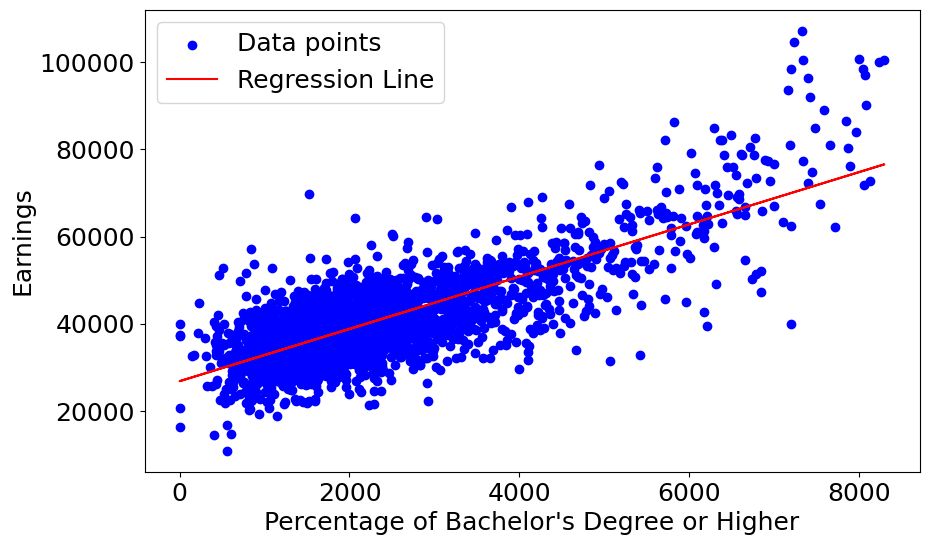

In [ ]:
# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Data points')

# Plotting the regression line
plt.plot(X, model.predict(X), color='red', label='Regression Line')

# Adding labels and title
plt.xlabel('Percentage of Bachelor\'s Degree or Higher')
plt.ylabel('Earnings')
# plt.title('Linear Regression: Earnings vs. Percentage of Bachelor\'s Degree or Higher')
plt.legend()

# Display the plot
plt.show()

# DP

In [ ]:
# Transpose the dataset for easier manipulation
data_transposed = data.T

# Display the transposed dataframe
data_transposed = data_transposed.astype(float)

data_transposed


,0,1,2,3,4,5,6,7,8,9,...,2542,2543,2544,2545,2546,2547,2548,2549,2550,2551
Population 25 years and over,539.0,465.0,1649.0,792.0,1264.0,1951.0,3015.0,5253.0,4957.0,1101.0,...,2854.0,777.0,12772.0,441.0,1460.0,595.0,27138.0,19611.0,148.0,581.0
Less than 9th grade,24.0,65.0,58.0,24.0,25.0,96.0,38.0,248.0,151.0,51.0,...,76.0,81.0,223.0,13.0,58.0,8.0,2037.0,479.0,6.0,6.0
9th to 12th grade,28.0,18.0,97.0,81.0,59.0,217.0,111.0,219.0,191.0,79.0,...,411.0,88.0,527.0,51.0,155.0,40.0,3588.0,778.0,12.0,63.0
High school graduate,209.0,239.0,762.0,367.0,472.0,796.0,948.0,2219.0,1299.0,429.0,...,1299.0,231.0,5075.0,216.0,720.0,245.0,11235.0,6638.0,77.0,277.0
Some college,78.0,47.0,292.0,129.0,323.0,321.0,795.0,835.0,915.0,169.0,...,452.0,182.0,2429.0,68.0,192.0,158.0,3952.0,3354.0,29.0,147.0
Associate degree,47.0,20.0,172.0,57.0,155.0,111.0,399.0,599.0,372.0,122.0,...,385.0,85.0,1243.0,23.0,178.0,25.0,2317.0,1903.0,11.0,51.0
Bachelor degree or higher,153.0,76.0,268.0,134.0,230.0,410.0,724.0,1133.0,2029.0,251.0,...,231.0,110.0,3275.0,70.0,157.0,119.0,4009.0,6459.0,13.0,37.0
Earnings,36786.0,35324.0,38149.0,36750.0,40752.0,32147.0,47583.0,42248.0,44172.0,36779.0,...,29160.0,36250.0,49064.0,36458.0,33484.0,30938.0,30952.0,47997.0,37344.0,32464.0


In [ ]:
sigma2_CLT = 456.62

noise1 = []
noise2 = []
noise3 = []
noise4 = []
noise5 = []
noise6 = []
for i in range(data_transposed.shape[1]):
  noise1.append(sample_dgauss(sigma2_CLT))
  noise2.append(sample_dgauss(sigma2_CLT))
  noise3.append(sample_dgauss(sigma2_CLT))
  noise4.append(sample_dgauss(sigma2_CLT))
  noise5.append(sample_dgauss(sigma2_CLT))
  noise6.append(sample_dgauss(sigma2_CLT))




# Adding the noise to the second column of the DataFrame
# second_column = data_transposed.iloc[1]
data_transposed.iloc[1] = data_transposed.iloc[1] + noise1
data_transposed.iloc[2] = data_transposed.iloc[2] + noise2
data_transposed.iloc[3] = data_transposed.iloc[3] + noise3
data_transposed.iloc[4] = data_transposed.iloc[4] + noise4
data_transposed.iloc[5] = data_transposed.iloc[5] + noise5
data_transposed.iloc[6] = data_transposed.iloc[6] + noise6


# # Adding the noise to the second column of the DataFrame
# second_column = data_transposed.rows[2]
# data_transposed[second_column] = data_transposed[second_column] + noise2

# # Adding the noise to the second column of the DataFrame
# second_column = data_transposed.rows[3]
# data_transposed[second_column] = data_transposed[second_column] + noise3

# # Adding the noise to the second column of the DataFrame
# second_column = data_transposed.rows[4]
# data_transposed[second_column] = data_transposed[second_column] + noise4

# Display the updated dataframe
data_transposed


,0,1,2,3,4,5,6,7,8,9,...,2542,2543,2544,2545,2546,2547,2548,2549,2550,2551
Population 25 years and over,539.0,465.0,1649.0,792.0,1264.0,1951.0,3015.0,5253.0,4957.0,1101.0,...,2854.0,777.0,12772.0,441.0,1460.0,595.0,27138.0,19611.0,148.0,581.0
Less than 9th grade,29.0,58.0,79.0,13.0,28.0,72.0,31.0,240.0,130.0,18.0,...,70.0,92.0,245.0,-28.0,67.0,6.0,2036.0,474.0,41.0,-57.0
9th to 12th grade,31.0,27.0,92.0,74.0,41.0,265.0,99.0,210.0,166.0,88.0,...,421.0,79.0,484.0,48.0,116.0,29.0,3634.0,761.0,35.0,57.0
High school graduate,202.0,241.0,775.0,365.0,446.0,788.0,931.0,2219.0,1284.0,430.0,...,1306.0,211.0,5107.0,223.0,749.0,255.0,11272.0,6651.0,61.0,290.0
Some college,84.0,37.0,295.0,131.0,329.0,333.0,796.0,874.0,961.0,172.0,...,475.0,195.0,2412.0,91.0,209.0,152.0,4004.0,3366.0,34.0,177.0
Associate degree,62.0,39.0,187.0,47.0,143.0,86.0,410.0,593.0,415.0,119.0,...,378.0,90.0,1253.0,13.0,157.0,12.0,2312.0,1923.0,-13.0,74.0
Bachelor degree or higher,189.0,76.0,276.0,138.0,224.0,409.0,730.0,1130.0,2045.0,264.0,...,221.0,88.0,3279.0,63.0,153.0,102.0,3961.0,6467.0,86.0,74.0
Earnings,36786.0,35324.0,38149.0,36750.0,40752.0,32147.0,47583.0,42248.0,44172.0,36779.0,...,29160.0,36250.0,49064.0,36458.0,33484.0,30938.0,30952.0,47997.0,37344.0,32464.0


In [ ]:
# Print the DataFrame with the modified first row
data_transposed = data_transposed.clip(lower=0)

# Calculate the sum of values in rows 1 to 4 (2nd to 5th row based on indexing that starts from 0)
sum_of_rows = data_transposed.iloc[1:7].sum(axis=0)

# Update the first row of the dataframe with the calculated sum
# Replace the 'Population 25 years and over' row with this sum
data_transposed.loc['Population 25 years and over'] = sum_of_rows


data_transposed


,0,1,2,3,4,5,6,7,8,9,...,2542,2543,2544,2545,2546,2547,2548,2549,2550,2551
Population 25 years and over,597.0,478.0,1704.0,768.0,1211.0,1953.0,2997.0,5266.0,5001.0,1091.0,...,2871.0,755.0,12780.0,438.0,1451.0,556.0,27219.0,19642.0,257.0,672.0
Less than 9th grade,29.0,58.0,79.0,13.0,28.0,72.0,31.0,240.0,130.0,18.0,...,70.0,92.0,245.0,0.0,67.0,6.0,2036.0,474.0,41.0,0.0
9th to 12th grade,31.0,27.0,92.0,74.0,41.0,265.0,99.0,210.0,166.0,88.0,...,421.0,79.0,484.0,48.0,116.0,29.0,3634.0,761.0,35.0,57.0
High school graduate,202.0,241.0,775.0,365.0,446.0,788.0,931.0,2219.0,1284.0,430.0,...,1306.0,211.0,5107.0,223.0,749.0,255.0,11272.0,6651.0,61.0,290.0
Some college,84.0,37.0,295.0,131.0,329.0,333.0,796.0,874.0,961.0,172.0,...,475.0,195.0,2412.0,91.0,209.0,152.0,4004.0,3366.0,34.0,177.0
Associate degree,62.0,39.0,187.0,47.0,143.0,86.0,410.0,593.0,415.0,119.0,...,378.0,90.0,1253.0,13.0,157.0,12.0,2312.0,1923.0,0.0,74.0
Bachelor degree or higher,189.0,76.0,276.0,138.0,224.0,409.0,730.0,1130.0,2045.0,264.0,...,221.0,88.0,3279.0,63.0,153.0,102.0,3961.0,6467.0,86.0,74.0
Earnings,36786.0,35324.0,38149.0,36750.0,40752.0,32147.0,47583.0,42248.0,44172.0,36779.0,...,29160.0,36250.0,49064.0,36458.0,33484.0,30938.0,30952.0,47997.0,37344.0,32464.0


In [ ]:
# Isolating the rows for "Bachelor's degree or higher" and "Population 25 to 64 years"
bachelors_or_higher = data_transposed.iloc[-2]

population_25_to_64 = data_transposed.iloc[0]


# print(bachelors_or_higher)
# print(population_25_to_64)

In [ ]:
# Calculating the percentage
percentage_bachelors_or_higher = (bachelors_or_higher / population_25_to_64) * 10000
# print(percentage_bachelors_or_higher)

## result

In [ ]:
# Preparing the data for linear regression
X_bureaus = percentage_bachelors_or_higher.values.reshape(-1, 1)  # Independent variable
y = data_transposed.loc['Earnings'].values  # Response

# Performing linear regression
model = LinearRegression()
model.fit(X_bureaus, y)

# Fix the intercept to 20228
model.intercept_ = fixed_intercept

# Coefficients (intercept is now fixed)
intercept = model.intercept_  # This will now be 20228
slope = model.coef_[0]

# R-squared value (unaffected by intercept change)
r_squared = model.score(X_bureaus, y)

(intercept, slope, r_squared)


(26815.698789811475, 5.57339388469245, 0.5502887019324642)

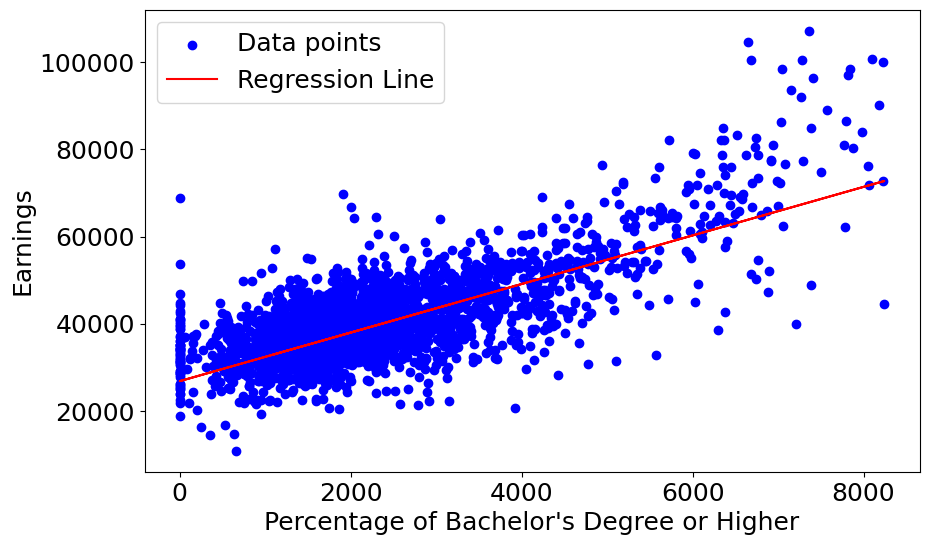

In [ ]:
# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X_bureaus, y, color='blue', label='Data points')

# Plotting the regression line
plt.plot(X_bureaus, model.predict(X_bureaus), color='red', label='Regression Line')

# Adding labels and title
plt.xlabel('Percentage of Bachelor\'s Degree or Higher')
plt.ylabel('Earnings')
# plt.title('Linear Regression: Earnings vs. Percentage of Bachelor\'s Degree or Higher')
plt.legend()

# Display the plot
plt.show()

# f-DP

In [ ]:
# Transpose the dataset for easier manipulation
data_transposed = data.T

# Display the transposed dataframe
data_transposed = data_transposed.astype(float)

data_transposed


,0,1,2,3,4,5,6,7,8,9,...,2542,2543,2544,2545,2546,2547,2548,2549,2550,2551
Population 25 years and over,539.0,465.0,1649.0,792.0,1264.0,1951.0,3015.0,5253.0,4957.0,1101.0,...,2854.0,777.0,12772.0,441.0,1460.0,595.0,27138.0,19611.0,148.0,581.0
Less than 9th grade,24.0,65.0,58.0,24.0,25.0,96.0,38.0,248.0,151.0,51.0,...,76.0,81.0,223.0,13.0,58.0,8.0,2037.0,479.0,6.0,6.0
9th to 12th grade,28.0,18.0,97.0,81.0,59.0,217.0,111.0,219.0,191.0,79.0,...,411.0,88.0,527.0,51.0,155.0,40.0,3588.0,778.0,12.0,63.0
High school graduate,209.0,239.0,762.0,367.0,472.0,796.0,948.0,2219.0,1299.0,429.0,...,1299.0,231.0,5075.0,216.0,720.0,245.0,11235.0,6638.0,77.0,277.0
Some college,78.0,47.0,292.0,129.0,323.0,321.0,795.0,835.0,915.0,169.0,...,452.0,182.0,2429.0,68.0,192.0,158.0,3952.0,3354.0,29.0,147.0
Associate degree,47.0,20.0,172.0,57.0,155.0,111.0,399.0,599.0,372.0,122.0,...,385.0,85.0,1243.0,23.0,178.0,25.0,2317.0,1903.0,11.0,51.0
Bachelor degree or higher,153.0,76.0,268.0,134.0,230.0,410.0,724.0,1133.0,2029.0,251.0,...,231.0,110.0,3275.0,70.0,157.0,119.0,4009.0,6459.0,13.0,37.0
Earnings,36786.0,35324.0,38149.0,36750.0,40752.0,32147.0,47583.0,42248.0,44172.0,36779.0,...,29160.0,36250.0,49064.0,36458.0,33484.0,30938.0,30952.0,47997.0,37344.0,32464.0


In [ ]:
sigma2_CLT = 343.27

noise1 = []
noise2 = []
noise3 = []
noise4 = []
noise5 = []
noise6 = []
for i in range(data_transposed.shape[1]):
  noise1.append(sample_dgauss(sigma2_CLT))
  noise2.append(sample_dgauss(sigma2_CLT))
  noise3.append(sample_dgauss(sigma2_CLT))
  noise4.append(sample_dgauss(sigma2_CLT))
  noise5.append(sample_dgauss(sigma2_CLT))
  noise6.append(sample_dgauss(sigma2_CLT))




# Adding the noise to the second column of the DataFrame
# second_column = data_transposed.iloc[1]
data_transposed.iloc[1] = data_transposed.iloc[1] + noise1
data_transposed.iloc[2] = data_transposed.iloc[2] + noise2
data_transposed.iloc[3] = data_transposed.iloc[3] + noise3
data_transposed.iloc[4] = data_transposed.iloc[4] + noise4
data_transposed.iloc[5] = data_transposed.iloc[5] + noise5
data_transposed.iloc[6] = data_transposed.iloc[6] + noise6


# # Adding the noise to the second column of the DataFrame
# second_column = data_transposed.rows[2]
# data_transposed[second_column] = data_transposed[second_column] + noise2

# # Adding the noise to the second column of the DataFrame
# second_column = data_transposed.rows[3]
# data_transposed[second_column] = data_transposed[second_column] + noise3

# # Adding the noise to the second column of the DataFrame
# second_column = data_transposed.rows[4]
# data_transposed[second_column] = data_transposed[second_column] + noise4

# Display the updated dataframe
data_transposed


,0,1,2,3,4,5,6,7,8,9,...,2542,2543,2544,2545,2546,2547,2548,2549,2550,2551
Population 25 years and over,539.0,465.0,1649.0,792.0,1264.0,1951.0,3015.0,5253.0,4957.0,1101.0,...,2854.0,777.0,12772.0,441.0,1460.0,595.0,27138.0,19611.0,148.0,581.0
Less than 9th grade,15.0,38.0,67.0,-6.0,32.0,98.0,28.0,261.0,153.0,28.0,...,60.0,84.0,230.0,-2.0,52.0,3.0,2020.0,465.0,37.0,23.0
9th to 12th grade,29.0,15.0,112.0,59.0,59.0,184.0,99.0,224.0,187.0,85.0,...,412.0,70.0,533.0,52.0,147.0,50.0,3578.0,793.0,39.0,51.0
High school graduate,176.0,219.0,786.0,394.0,475.0,783.0,959.0,2231.0,1286.0,418.0,...,1292.0,246.0,5054.0,195.0,709.0,225.0,11234.0,6647.0,91.0,303.0
Some college,83.0,27.0,292.0,155.0,336.0,301.0,809.0,855.0,934.0,165.0,...,466.0,172.0,2471.0,94.0,195.0,151.0,3986.0,3382.0,64.0,152.0
Associate degree,50.0,27.0,189.0,83.0,164.0,104.0,416.0,610.0,390.0,135.0,...,427.0,75.0,1234.0,38.0,170.0,36.0,2327.0,1897.0,-22.0,24.0
Bachelor degree or higher,167.0,57.0,293.0,129.0,243.0,396.0,739.0,1099.0,2047.0,260.0,...,229.0,94.0,3282.0,65.0,172.0,85.0,4021.0,6486.0,0.0,22.0
Earnings,36786.0,35324.0,38149.0,36750.0,40752.0,32147.0,47583.0,42248.0,44172.0,36779.0,...,29160.0,36250.0,49064.0,36458.0,33484.0,30938.0,30952.0,47997.0,37344.0,32464.0


In [ ]:
# Print the DataFrame with the modified first row
data_transposed = data_transposed.clip(lower=0)

# Calculate the sum of values in rows 1 to 4 (2nd to 5th row based on indexing that starts from 0)
sum_of_rows = data_transposed.iloc[1:7].sum(axis=0)

# Update the first row of the dataframe with the calculated sum
# Replace the 'Population 25 years and over' row with this sum
data_transposed.loc['Population 25 years and over'] = sum_of_rows


data_transposed


,0,1,2,3,4,5,6,7,8,9,...,2542,2543,2544,2545,2546,2547,2548,2549,2550,2551
Population 25 years and over,520.0,383.0,1739.0,820.0,1309.0,1866.0,3050.0,5280.0,4997.0,1091.0,...,2886.0,741.0,12804.0,444.0,1445.0,550.0,27166.0,19670.0,231.0,575.0
Less than 9th grade,15.0,38.0,67.0,0.0,32.0,98.0,28.0,261.0,153.0,28.0,...,60.0,84.0,230.0,0.0,52.0,3.0,2020.0,465.0,37.0,23.0
9th to 12th grade,29.0,15.0,112.0,59.0,59.0,184.0,99.0,224.0,187.0,85.0,...,412.0,70.0,533.0,52.0,147.0,50.0,3578.0,793.0,39.0,51.0
High school graduate,176.0,219.0,786.0,394.0,475.0,783.0,959.0,2231.0,1286.0,418.0,...,1292.0,246.0,5054.0,195.0,709.0,225.0,11234.0,6647.0,91.0,303.0
Some college,83.0,27.0,292.0,155.0,336.0,301.0,809.0,855.0,934.0,165.0,...,466.0,172.0,2471.0,94.0,195.0,151.0,3986.0,3382.0,64.0,152.0
Associate degree,50.0,27.0,189.0,83.0,164.0,104.0,416.0,610.0,390.0,135.0,...,427.0,75.0,1234.0,38.0,170.0,36.0,2327.0,1897.0,0.0,24.0
Bachelor degree or higher,167.0,57.0,293.0,129.0,243.0,396.0,739.0,1099.0,2047.0,260.0,...,229.0,94.0,3282.0,65.0,172.0,85.0,4021.0,6486.0,0.0,22.0
Earnings,36786.0,35324.0,38149.0,36750.0,40752.0,32147.0,47583.0,42248.0,44172.0,36779.0,...,29160.0,36250.0,49064.0,36458.0,33484.0,30938.0,30952.0,47997.0,37344.0,32464.0


In [ ]:
# Isolating the rows for "Bachelor's degree or higher" and "Population 25 to 64 years"
bachelors_or_higher = data_transposed.iloc[-2]

population_25_to_64 = data_transposed.iloc[0]


# print(bachelors_or_higher)
# print(population_25_to_64)

In [ ]:
# Calculating the percentage
percentage_bachelors_or_higher = (bachelors_or_higher / population_25_to_64) * 10000
# print(percentage_bachelors_or_higher)

## result

In [ ]:
# Preparing the data for linear regression
X_fdp = percentage_bachelors_or_higher.values.reshape(-1, 1)  # Independent variable
y = data_transposed.loc['Earnings'].values  # Response

# Performing linear regression
model = LinearRegression()
model.fit(X_fdp, y)

# Fix the intercept to 20228
model.intercept_ = fixed_intercept

# Coefficients (intercept is now fixed)
intercept = model.intercept_  # This will now be 20228
slope = model.coef_[0]

# R-squared value (unaffected by intercept change)
r_squared = model.score(X_fdp, y)

(intercept, slope, r_squared)


(26815.698789811475, 5.57939311933434, 0.5463307571329239)

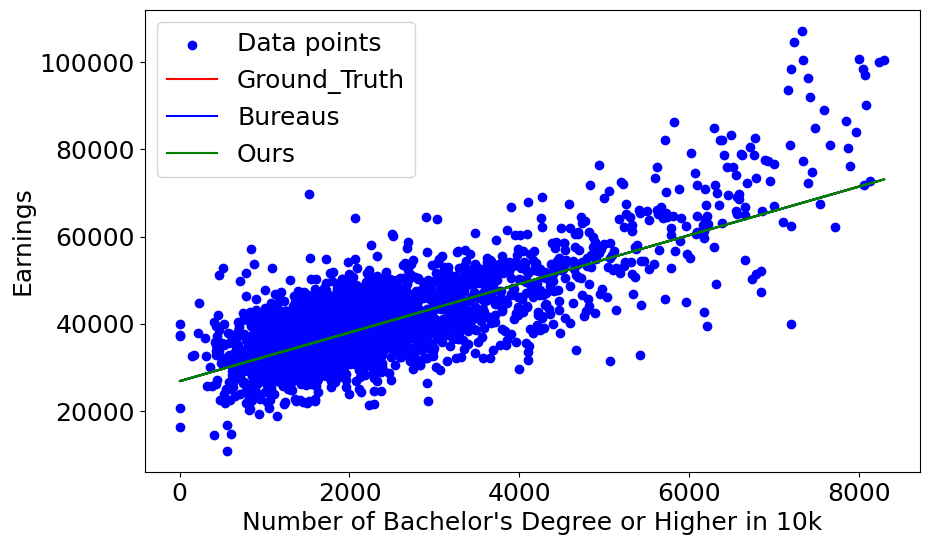

In [ ]:
# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Data points')

# Plotting the regression line
plt.plot(X_fdp, model.predict(X_fdp), color='red', label='Ground_Truth')
plt.plot(X_bureaus, model.predict(X_bureaus), color='blue', label='Bureaus')
plt.plot(X, model.predict(X), color='green', label='Ours')

# Adding labels and title
plt.xlabel('Number of Bachelor\'s Degree or Higher in 10k')
plt.ylabel('Earnings')
# plt.title('Linear Regression: Earnings vs. Percentage of Bachelor\'s Degree or Higher')
plt.legend()

# Display the plot
plt.show()

# **Comparison**

In [ ]:
"""
Bureaus
"""

state = (abs(8.806983545365078 - 8.805970599175412) + abs(8.806983545365078 - 8.808540578993705) + abs(8.806983545365078 - 8.807167199740322))/3
print(state)

metro = (abs(4.7869692693909345 - 4.785943386876841) + abs(4.7869692693909345 - 4.788103621036882) + abs(4.7869692693909345 - 4.789345919461185))/3
print(metro)

place = (abs(5.051866196933438 - 4.606129509988232) + abs(5.051866196933438 - 4.557306810980588) + abs(5.051866196933438 - 4.687888175584304) )/3
print(place)

county = (abs(4.746337675136961 - 4.754201448848889) + abs(4.746337675136961 - 4.7334140215778095) + abs(4.746337675136961 - 4.720920571282864) )/3
print(county)

subcounty = (abs(5.993392329113249 - 5.607473237684069) + abs(5.993392329113249 - 5.614650132259581) + abs(5.993392329113249 - 5.533764955709513))/3
print(subcounty)

tract = (abs(6.23728023824975 - 6.265895728868404) + abs(6.23728023824975 - 6.269284114267994) + abs(6.23728023824975 - 6.260011565147262))/3
print(tract)

zip = (abs(5.041939734384882 - 4.811121101199441) + abs(5.041939734384882 - 4.802286793681008) + abs(5.041939734384882 - 4.861542426684722))/3
print(zip)

0.0009178780645123416
0.001512294743430509
0.43475803141573
0.015401510375058733
0.40809622056219447
0.0277835645114702
0.2169562938631584


In [ ]:
"""
f-DP
"""

f_state = (abs(8.806983545365078 - 8.806492250094921) + abs(8.806983545365078 - 8.807483970263474) + abs(8.806983545365078 - 8.807077817492122))/3
print(f_state)

f_metro = (abs(4.7869692693909345 - 4.786451395632789) + abs(4.7869692693909345 - 4.786117385611587) + abs(4.7869692693909345 - 4.7874937081859645))/3
print(f_metro)

f_place = (abs(5.051866196933438 - 4.7854401786982805) + abs(5.051866196933438 - 4.79560364320874) + abs(5.051866196933438 - 4.811022771230189) )/3
print(f_place)

f_county = (abs(4.746337675136961 - 4.74529248070748) + abs(4.746337675136961 - 4.724175166791256) + abs(4.746337675136961 - 4.743134802801028) )/3
print(f_county)

f_subcounty = (abs(5.993392329113249 - 5.639328739249512) + abs(5.993392329113249 - 5.624226208284243) + abs(5.993392329113249 - 5.61369972850102))/3
print(f_subcounty)

f_tract = (abs(6.23728023824975 - 6.269858904398053) + abs(6.23728023824975 - 6.268635278136118) + abs(6.23728023824975 - 6.232239831470972))/3
print(f_tract)

f_zip = (abs(5.041939734384882 - 4.82472456775259) + abs(5.041939734384882 - 4.902477747409982) + abs(5.041939734384882 - 4.913220486869971))/3
print(f_zip)

0.00036199743186552763
0.0006313987775075821
0.2545106658877012
0.008803525037039664
0.3676407704349902
0.022991370937816374
0.1617988003740344


# **Plot**

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive is already the newest version (2021.20220204-1).
texlive-fonts-recommended is already the newest version (2021.20220204-1).
texlive-latex-extra is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


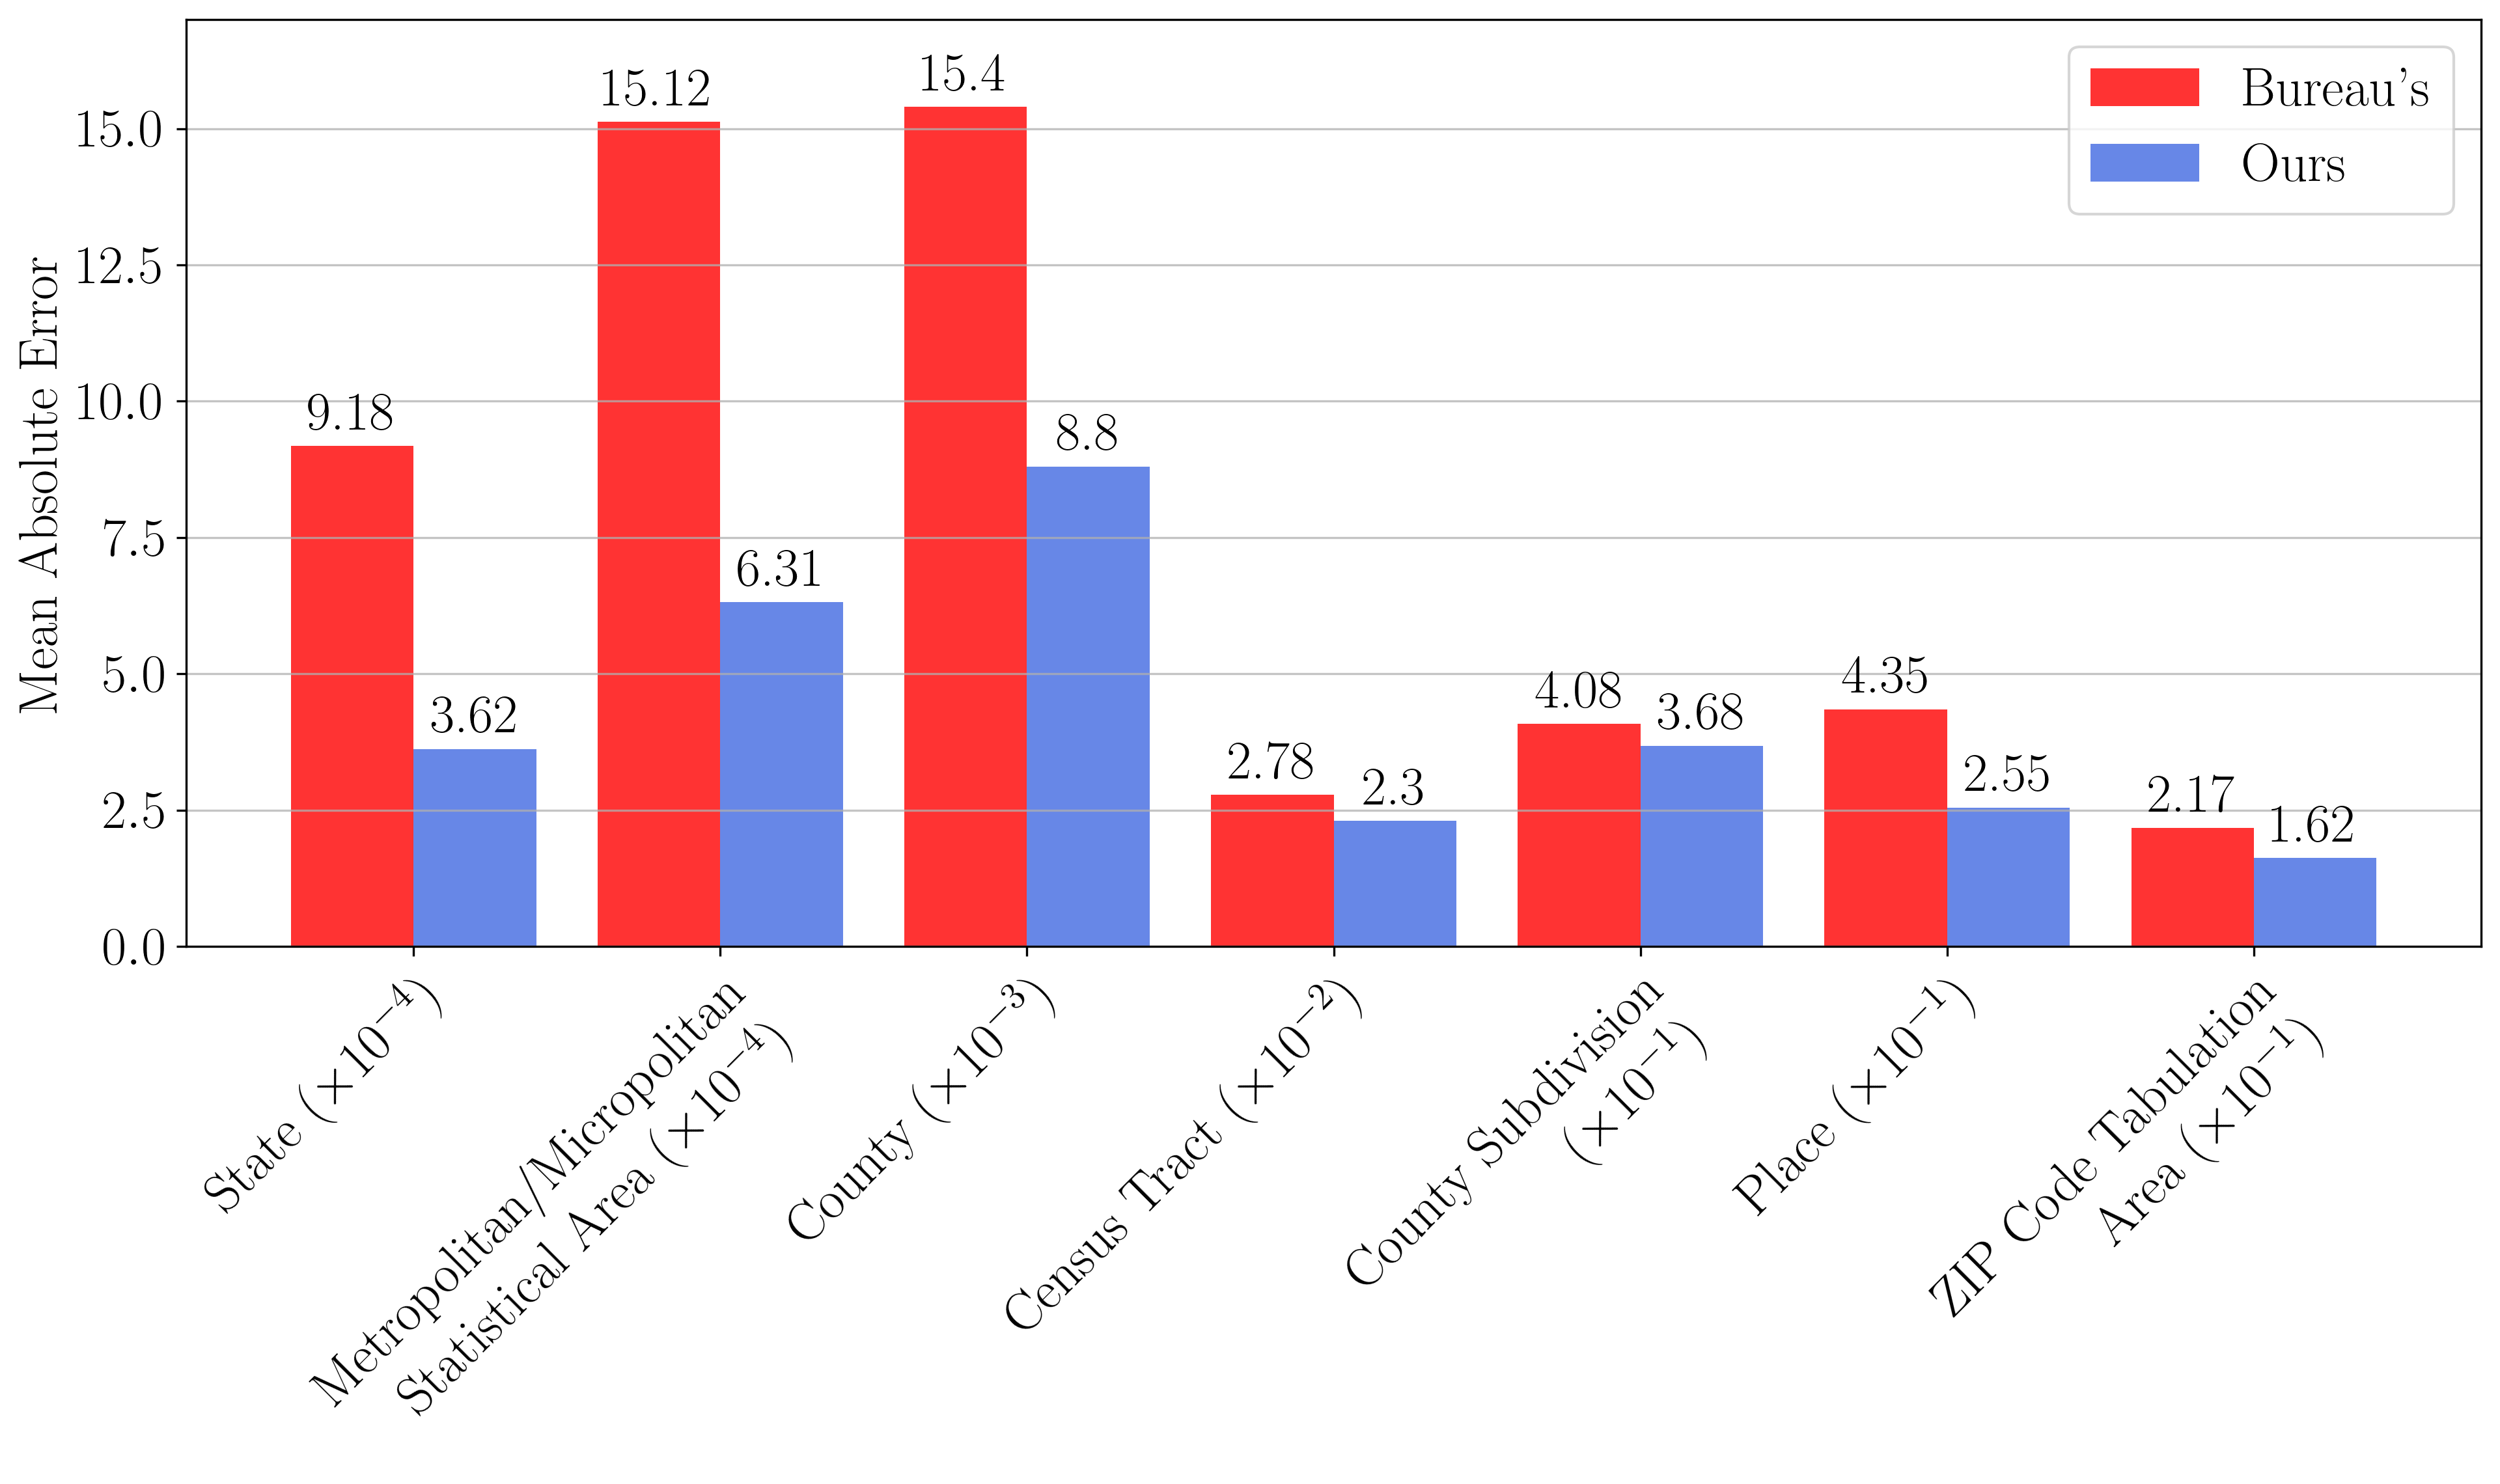

In [ ]:
from sklearn.isotonic import isotonic_regression
from sklearn.linear_model import LinearRegression
import cvxpy as cp
import numpy as np
import csv, os
from scipy import stats
from sklearn import metrics
import itertools
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statistics
from scipy.stats import levene
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

!apt-get install -y texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super

# Set the text properties to use LaTeX fonts with Computer Modern
plt.rcParams.update({
    'text.usetex': True,  # Use LaTeX for rendering text
    'font.family': 'serif',  # Use a serif font family (which will be Computer Modern)
    'font.serif': ['Computer Modern Roman'],  # Explicitly use the Computer Modern font
    'axes.unicode_minus': False,  # Ensure minus signs are displayed correctly
    'font.size': 20,  #In a row, use 20 for single picture, # 30 for double figures, # 55 for four figures
    'figure.figsize': (13, 8),  # Figure size in inches
    'figure.dpi': 300,  # Dots per inch (high resolution)
})

def format_func(value, tick_number):
    if value < 10:
        return f"{value:.2f}"
    elif value < 100:
        return f"{value:.1f}"
    else:
        return f"{int(value)}"


geographic_levels = ["State (${\\times 10^{-4}}$)", "Metropolitan/Micropolitan \n Statistical Area ($\\times {10^{-4}}$)", "County ($\\times {10^{-3}}$)",
                     "Census Tract ($\\times {10^{-2}}$)", "County Subdivision \n ($\\times {10^{-1}}$)", "Place ($\\times {10^{-1}}$)",
                     "ZIP Code Tabulation \n Area ($\\times {10^{-1}}$)"]
old_mse_list = [state * 10**4, metro * 10**4, county * 10**3, tract * 10**2, subcounty * 10**1, place * 10**1, zip * 10**1]
new_mse_list = [f_state * 10**4, f_metro * 10**4, f_county * 10**3, f_tract * 10**2, f_subcounty * 10**1, f_place * 10**1, f_zip * 10**1]

fig, ax = plt.subplots()

total_bar_width = 0.8

bar_positions_1 = np.arange(len(geographic_levels))
bar_positions_2 = bar_positions_1 + total_bar_width/2

bar_width = total_bar_width / 2

bars_1 = ax.bar(bar_positions_1, old_mse_list, bar_width, alpha=0.8, color='red', label='Bureau’s  ')
bars_2 = ax.bar(bar_positions_2, new_mse_list, bar_width, alpha=0.8, color='royalblue', label='Ours  ')

for bar in bars_1 + bars_2:
    height = round(bar.get_height(), 2)
    ax.annotate(f'{height}', (bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 2),  # Adjust this value to move the text up or down
                textcoords='offset points',
                ha='center', va='bottom')

plt.grid(axis='y', alpha=0.75)
# ax.set_xlabel('Mean Absolute Error')
ax.set_ylabel('Mean Absolute Error')
ax.set_ylim(0, 17)
ax.set_xticks(bar_positions_1 + total_bar_width / 4)
ax.set_xticklabels(geographic_levels, rotation=45, ha="right", rotation_mode="anchor")
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Research/Discrete Gaussian Mechanism/Results/Figures_Allocation_2022_08/downstream_task.pdf", bbox_inches='tight')
plt.show()


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive is already the newest version (2021.20220204-1).
texlive-fonts-recommended is already the newest version (2021.20220204-1).
texlive-latex-extra is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


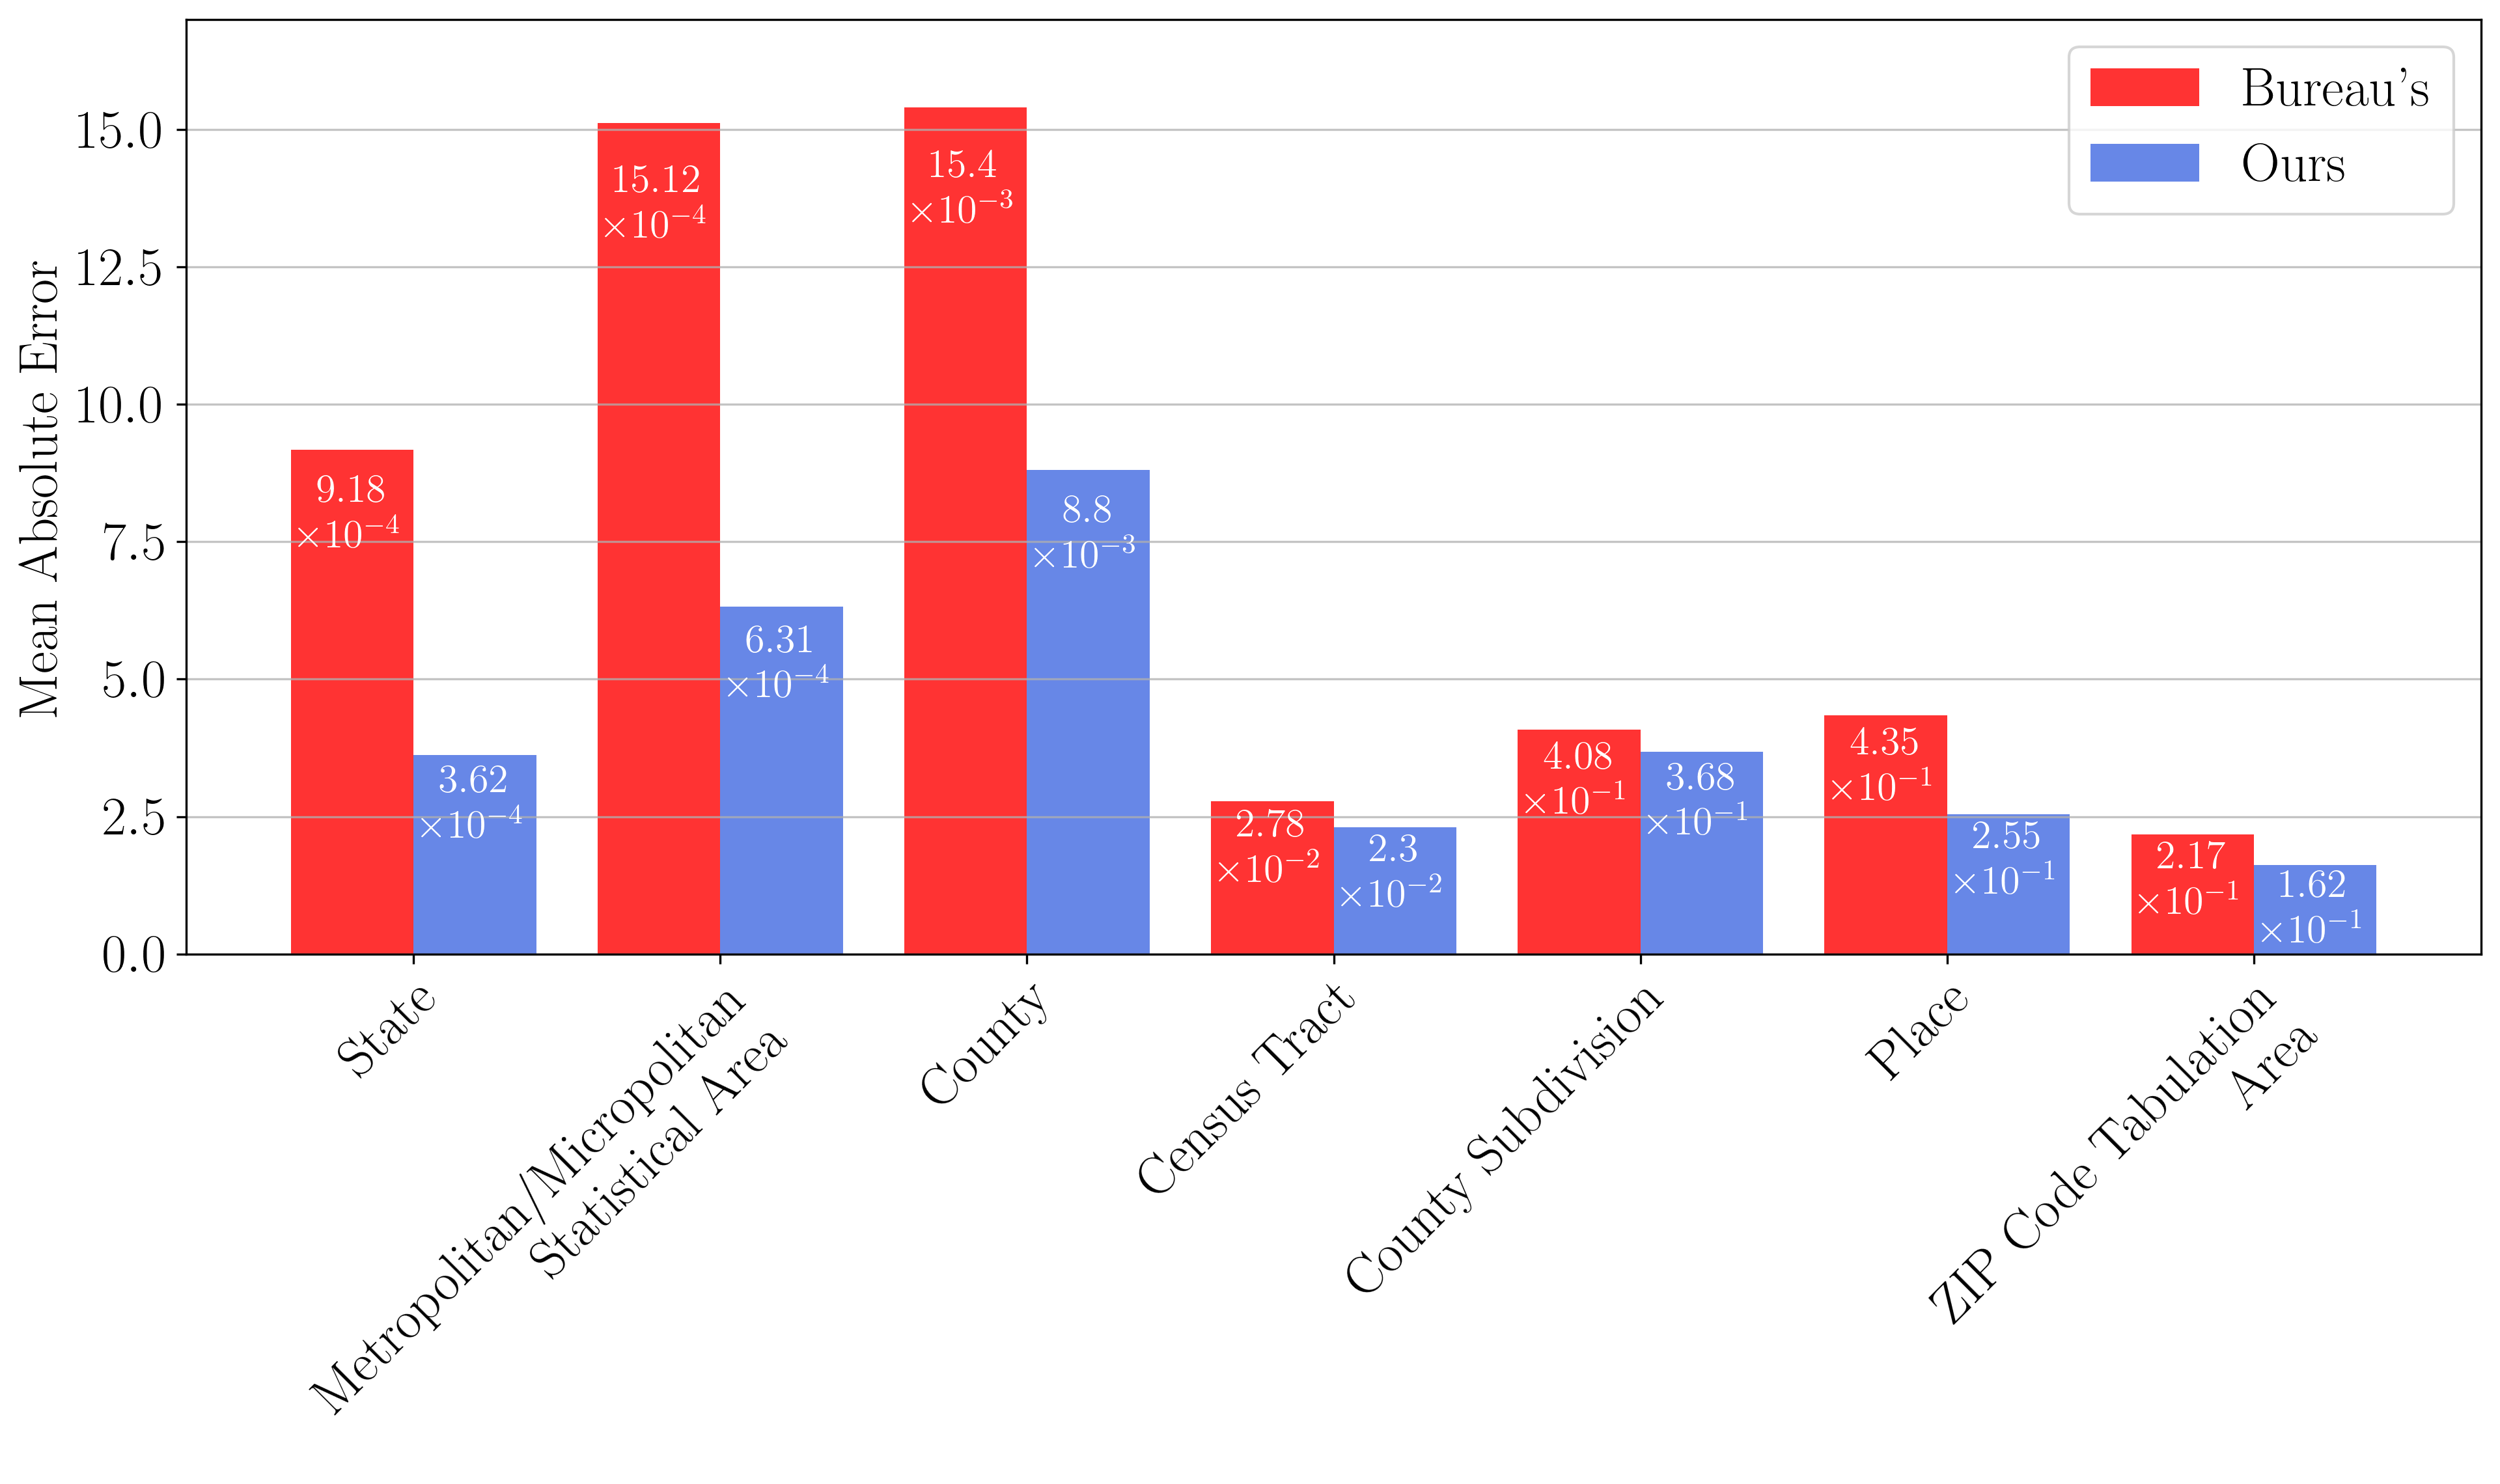

In [ ]:
from sklearn.isotonic import isotonic_regression
from sklearn.linear_model import LinearRegression
import cvxpy as cp
import numpy as np
import csv, os
from scipy import stats
from sklearn import metrics
import itertools
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statistics
from scipy.stats import levene
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

!apt-get install -y texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super

# Set the text properties to use LaTeX fonts with Computer Modern
plt.rcParams.update({
    'text.usetex': True,  # Use LaTeX for rendering text
    'font.family': 'serif',  # Use a serif font family (which will be Computer Modern)
    'font.serif': ['Computer Modern Roman'],  # Explicitly use the Computer Modern font
    'axes.unicode_minus': False,  # Ensure minus signs are displayed correctly
    'font.size': 20,  # In a row, use 20 for a single picture, # 30 for double figures, # 55 for four figures
    'figure.figsize': (13, 8),  # Figure size in inches
    'figure.dpi': 300,  # Dots per inch (high resolution)
})

def format_func(value, tick_number):
    if value < 10:
        return f"{value:.2f}"
    elif value < 100:
        return f"{value:.1f}"
    else:
        return f"{int(value)}"

geographic_levels = ["State", "Metropolitan/Micropolitan \n Statistical Area", "County",
                     "Census Tract", "County Subdivision", "Place",
                     "ZIP Code Tabulation \n Area"]

# Placeholder values for MSE; replace these with the actual variables
old_mse_list = [state * 10**4, metro * 10**4, county * 10**3, tract * 10**2, subcounty * 10**1, place * 10**1, zip * 10**1]
new_mse_list = [f_state * 10**4, f_metro * 10**4, f_county * 10**3, f_tract * 10**2, f_subcounty * 10**1, f_place * 10**1, f_zip * 10**1]

fig, ax = plt.subplots()

total_bar_width = 0.8
bar_positions_1 = np.arange(len(geographic_levels))
bar_positions_2 = bar_positions_1 + total_bar_width / 2
bar_width = total_bar_width / 2

bars_1 = ax.bar(bar_positions_1, old_mse_list, bar_width, alpha=0.8, color='red', label='Bureau’s')
bars_2 = ax.bar(bar_positions_2, new_mse_list, bar_width, alpha=0.8, color='royalblue', label='Ours')

# Annotate bars with values and scientific notation
notations = ['10^{-4}', '10^{-4}', '10^{-3}', '10^{-2}', '10^{-1}', '10^{-1}', '10^{-1}']

for i, bar in enumerate(bars_1):
    height = round(bar.get_height(), 2)
    ax.annotate(f'{height}\n$\\times {notations[i]}$',
                (bar.get_x() + bar.get_width() / 2, height - height * 0.05),  # Adjust position to place text inside the bar
                xytext=(0, 0), textcoords='offset points',
                ha='center', va='top', color='white', fontsize=15)  # White text, smaller font size

for i, bar in enumerate(bars_2):
    height = round(bar.get_height(), 2)
    ax.annotate(f'{height}\n$\\times {notations[i]}$',
                (bar.get_x() + bar.get_width() / 2, height - height * 0.05),  # Adjust position to place text inside the bar
                xytext=(0, 0), textcoords='offset points',
                ha='center', va='top', color='white', fontsize=15)  # White text, smaller font size

plt.grid(axis='y', alpha=0.75)
ax.set_ylabel('Mean Absolute Error')
ax.set_ylim(0, 17)
ax.set_xticks(bar_positions_1 + total_bar_width / 4)
ax.set_xticklabels(geographic_levels, rotation=45, ha="right", rotation_mode="anchor")
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Research/Discrete Gaussian Mechanism/Results/Figures_Allocation_2022_08/downstream_task.pdf", bbox_inches='tight')
plt.show()
